# Второе приложение

In [90]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
import PIL
from matplotlib import pyplot as plt

workers = 0 if os.name == 'nt' else 4

In [92]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [93]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Загружаем фотографии

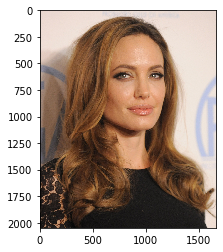

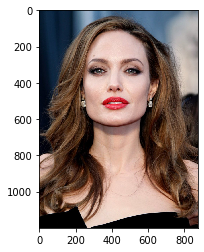

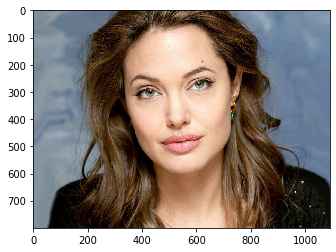

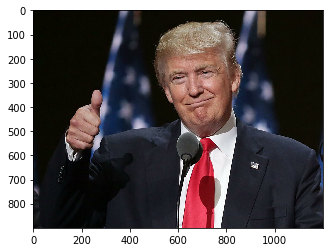

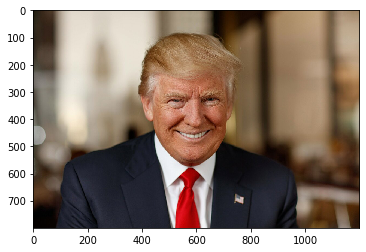

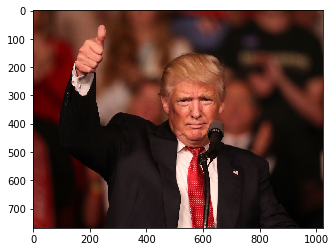

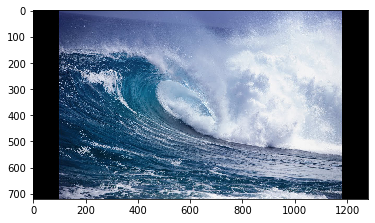

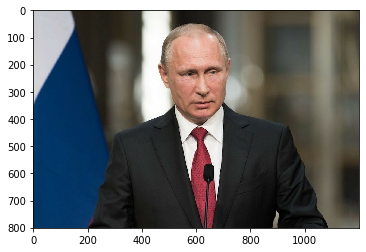

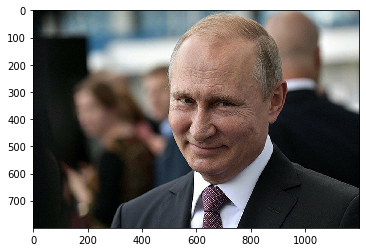

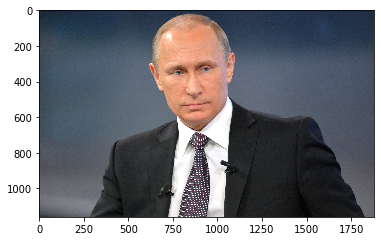

In [101]:
from IPython.display import Image
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('../data/test_images')
# print(dataset.class_to_idx.items())
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

for x, y in loader:
    plt.figure()
    plt.imshow(x)


#### Обнаружение лиц

In [104]:
aligned = []
names = []
k = 0
for x, y in loader:
#     plt.figure()
#     display(x)
    x_aligned, prob = mtcnn(x, return_prob=True)
#     print(x_aligned)
    if x_aligned is not None:
        k += 1
        print(f'{dataset.idx_to_class[y]}_{k}: Лицо обнаружено с вероятностью: {prob}')
        aligned.append(x_aligned)
        names.append(f'{dataset.idx_to_class[y]}_{k}')
    else:
        print(f'{dataset.idx_to_class[y]}: Лицо не обнаружено')

angelina_jolie_1: Лицо обнаружено с вероятностью: 0.9999825954437256
angelina_jolie_2: Лицо обнаружено с вероятностью: 0.9998111128807068
angelina_jolie_3: Лицо обнаружено с вероятностью: 0.9980320334434509
donald_trump_4: Лицо обнаружено с вероятностью: 0.9992054104804993
donald_trump_5: Лицо обнаружено с вероятностью: 0.999046266078949
donald_trump_6: Лицо обнаружено с вероятностью: 0.9995461106300354
just_picture: Лицо не обнаружено
vladimir_putin_7: Лицо обнаружено с вероятностью: 0.9999531507492065
vladimir_putin_8: Лицо обнаружено с вероятностью: 0.9999496936798096
vladimir_putin_9: Лицо обнаружено с вероятностью: 0.9999866485595703


In [105]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Создаем матрицу дистанций между объектами

In [114]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
res = pd.DataFrame(dists, columns=names, index=names)
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)
def styling(s):
    if s < 1:
        return 'background-color: rgb(22, 224, 22)' 
    else: 
        return ''
res.style.applymap(styling)

,angelina_jolie_1,angelina_jolie_2,angelina_jolie_3,donald_trump_4,donald_trump_5,donald_trump_6,vladimir_putin_7,vladimir_putin_8,vladimir_putin_9
angelina_jolie_1,0,0.681293,0.814391,1.4036,1.43395,1.35077,1.35277,1.41206,1.32891
angelina_jolie_2,0.681293,0,0.863923,1.43372,1.46388,1.41717,1.41534,1.41763,1.38086
angelina_jolie_3,0.814391,0.863923,0,1.40773,1.44785,1.4063,1.4333,1.44562,1.4382
donald_trump_4,1.4036,1.43372,1.40773,0,0.63059,0.652204,1.30562,1.35259,1.31952
donald_trump_5,1.43395,1.46388,1.44785,0.63059,0,0.490508,1.26961,1.27887,1.31419
donald_trump_6,1.35077,1.41717,1.4063,0.652204,0.490508,0,1.17028,1.21441,1.23787
vladimir_putin_7,1.35277,1.41534,1.4333,1.30562,1.26961,1.17028,0,0.502054,0.418525
vladimir_putin_8,1.41206,1.41763,1.44562,1.35259,1.27887,1.21441,0.502054,0,0.543975
vladimir_putin_9,1.32891,1.38086,1.4382,1.31952,1.31419,1.23787,0.418525,0.543975,0
